# Realizar predicción con algoritmo del profe

En esta etapa se tomará el algoritmo del profe para predecir la temperatura de la noche:

$$T_h(z) = T_s - k(z)$$

Donde:
- $T_h$ es la temperatura horaria durante la noche
- $T_s$ es la temperatura a las 19:00 hrs
- $k(z)$ es el factor de velocidad de enfriamiento. Debe aumentar al bajar la humedad del aire y al diminuir la nubosidad, su valor mas alto debiera ocurrir con muy bajas HRelativas y cero nubosidad. Tambien debiera aumentar positivamente con la presion atmosferica.
- $z$ son las horas que han pasado desde las 19:00 hrs

El problema es cómo calcular el factor de enfriamiento. Si depende de la nubosidad, entonces no se puede calcular a partir de los datos que tenemos.

Se deben realizar los siguientes pasos para la tarea:
1. Cargar las curvas de temperatura y todas las demás de alguna estación, entre 19:00 y 7:00
2. Iterar sobre los días y calcular el error cuadrático medio de la predicción

In [60]:
import pandas as pd
import numpy as np
from datetime import time, date, datetime
import matplotlib.pyplot as plt

In [13]:
# cargar datos y curvas de tiempo
def process(df):
    print("-> drop repeated, before len: ", len(df))
    df = df.drop(df[df.duplicated(['Codigo', 'Fecha', 'Hora'])].index)
    print("-> after len: ", len(df))
    df = df.sort_values(by =['Codigo', 'Fecha', 'Hora'])
    df = df.reset_index(drop=True)
    return df

meses = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril", 
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

def is_summer(d):
    ini = datetime(day=21, month=12, year=2009)
    last_day = datetime(day=31, month=12, year=2009)
    first_day = datetime(day=1, month=1, year=2010)
    end = datetime(day=20, month=3, year=2010)
    return ini <= d <= last_day or first_day <= d < end

def is_fall(d):
    ini = datetime(day=20, month=3, year=2010)
    end = datetime(day=21, month=6, year=2010)
    return ini <= d < end

def is_winter(d):
    ini = datetime(day=21, month=6, year=2010)
    last_day = datetime(day=30, month=6, year=2010)
    first_day = datetime(day=1, month=7, year=2009)
    end = datetime(day=22, month=9, year=2009)
    return ini <= d <= last_day or first_day <= d < end

def is_spring(d):
    ini = datetime(day=22, month=9, year=2009)
    end = datetime(day=21, month=12, year=2009)
    return ini <= d < end

def read_year(file1, file2):
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)
#     df3 = pd.read_excel(file3)
    df = pd.concat([df1, df2], ignore_index=True)
    df = process(df)
    df.columns = ["Codigo", "Fecha", "Hora", "Temp.", "Hum.", "Dir.Viento", "Vel.Viento", "Precip.", "Rad.Sol", "P.Atm"]
    
    season = []
    for v in df["Fecha"]:
        d = v.to_pydatetime()
        if is_summer(d):
            season.append("Verano")
        elif is_fall(d):
            season.append("Otoño")
        elif is_winter(d):
            season.append("Invierno")
        elif is_spring(d):
            season.append("Primavera")
        else:
            raise ValueError("Fallo")
            
    df["Estacion"] = season
#     df["Hora"] = [round(x.hour * 60 + x.minute) for x in df["Hora"]]
    df["Mes"] = [meses.get(int(x.month), "None") for x in df["Fecha"]]
    df["Dia"] = [x.date() for x in df["Fecha"]]
    df = df.drop(["Codigo", "Fecha"], axis=1)
    print(df.count())
    df.head()
    return df


In [14]:
file1 = "../data/PAULA/DEL MAULE/LINARES/Linares-01-01-2010-30-06-2010.xls"
file2 = "../data/PAULA/DEL MAULE/LINARES/Linares-01-07-2009-31-12-2009.xls"

df1 = read_year(file1, file2)
df1

-> drop repeated, before len:  31501
-> after len:  31501
Hora          31501
Temp.         31501
Hum.          31501
Dir.Viento    31501
Vel.Viento    31501
Precip.       31501
Rad.Sol       31501
P.Atm         31501
Estacion      31501
Mes           31501
Dia           31501
dtype: int64


,Hora,Temp.,Hum.,Dir.Viento,Vel.Viento,Precip.,Rad.Sol,P.Atm,Estacion,Mes,Dia
0,00:00:00,7.3,96.7,32,1.3,0.0,1,1002.4,Invierno,Julio,2009-07-01
1,00:15:00,6.9,97.1,42,0.9,0.0,1,1002.4,Invierno,Julio,2009-07-01
2,00:30:00,7.1,97.3,32,1.3,0.2,1,1002.6,Invierno,Julio,2009-07-01
3,00:45:00,7.0,97.1,18,1.3,0.0,1,1002.7,Invierno,Julio,2009-07-01
4,01:00:00,6.9,97.0,28,1.3,0.0,1,1002.9,Invierno,Julio,2009-07-01
5,01:15:00,6.7,97.2,34,1.1,0.0,1,1002.8,Invierno,Julio,2009-07-01
6,01:30:00,6.7,97.4,28,1.1,0.0,1,1002.9,Invierno,Julio,2009-07-01
7,01:45:00,6.5,97.3,38,0.9,0.0,1,1002.9,Invierno,Julio,2009-07-01
8,02:00:00,6.8,97.3,32,1.1,0.0,1,1002.8,Invierno,Julio,2009-07-01
9,02:15:00,7.0,97.3,29,0.9,0.0,1,1003.0,Invierno,Julio,2009-07-01


In [82]:
# ahora hay que separar por días y en las zonas de interés
def encontrar_dias(df, hora_inicio, hora_final):
    """
    Esta funcion entrega un diccionario con los dias como clave y un dataframe dentro de este con
    las distintas variables como:
        - temperatura
        - humedad
        - rad.Solar
        - etc
    
    El dia contiene la información entre ciertas horas de interés
    """
    
    dias = {}
    inicio = df['Dia'][0]
    index2add = []
    
    if not (hora_inicio > hora_final):
        print('ERROR ... la hora inicial debe ser mayor a la final ' +
               'ej: hora_inicio = 19:00 hora_final = 7:00')
        return {}
    
    for idx, hora in enumerate(df['Hora']):
        if hora < hora_final or hora >= hora_inicio:
            index2add.append(idx)
        elif hora == hora_final:
#             print(index2add)
            aux_df = df.loc[index2add]
            aux_df['Hora'] = [round(x.hour * 60 + x.minute) for x in aux_df['Hora']]
            dias[df['Dia'][idx]] = aux_df
            index2add = []
    
    return dias

In [85]:
dias = encontrar_dias(df1, time(19,0), time(7,0))

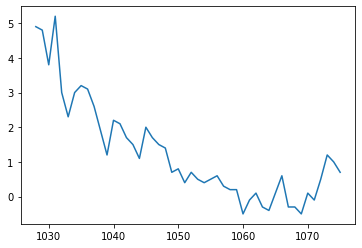

In [86]:
value = list(dias.keys())
plt.plot(dias[value[11]]['Temp.'])